# Replicated Stochastic Gradient Descent for Federated Learning

Notebook for the testing of the FedAvg algorithm and comparing its adaption to the r-SGD entropy algorithm

Notebook structure:
1. Imports & GPU check
2. Datasets 
3. Neural Network Architectures
4. Federated Training
5. FedAvg tests
6. rSGD tests
7. Comparison and Graphs

# 1. Imports & GPU

In [1]:
# Imports
import json
import copy
import time
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from modules.utils import get_dataset, server_aggregate, test_metrics, replicas_distance
from modules.partitioning import iid_partition, non_iid_partition
from modules.Nets import mnist_CNN, cifar_CNN
from modules.localUpdate import ClientUpdate, ClientEval

In [2]:
# Checking GPUs
torch.cuda.is_available()  # no gpu on laptop

True

### 2. Datasets
Implemented "mnist", "fmnist" and "cifar10", datasets will be downloaded only the first run

In [3]:
trainset, testset = get_dataset("fmnist") # will download the first time
print("Image Shape/Network input shape: {}".format(trainset.data[0].shape))

Image Shape/Network input shape: torch.Size([28, 28])


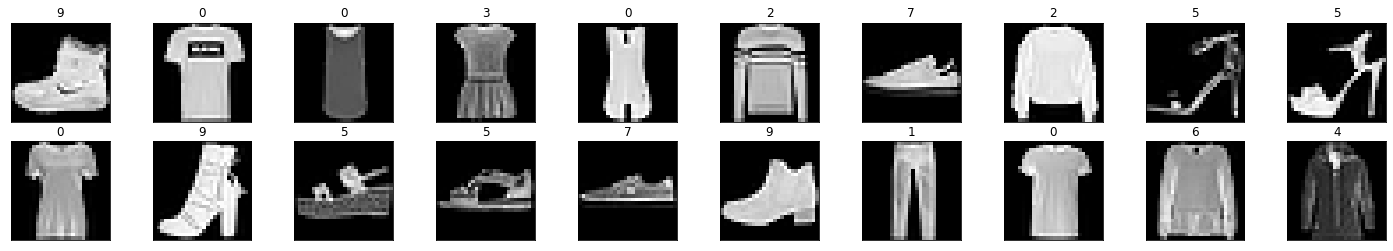

In [4]:
# Image example
figure = plt.figure(figsize=(25,4))
for i in range(20):
    axis = figure.add_subplot(2, int(20/2), i+1, xticks=[], yticks=[])
    data = trainset.data[i]
    data = data.numpy()

    target = trainset.targets[i]
    target = target.numpy()
    plt.imshow(data, cmap = 'gray')
    axis.set_title(target)

In [5]:
trainset, testset = get_dataset("cifar10")
print("Image Shape/Network input shape: {}".format(trainset.data[0].shape))

Files already downloaded and verified
Files already downloaded and verified
Image Shape/Network input shape: (32, 32, 3)


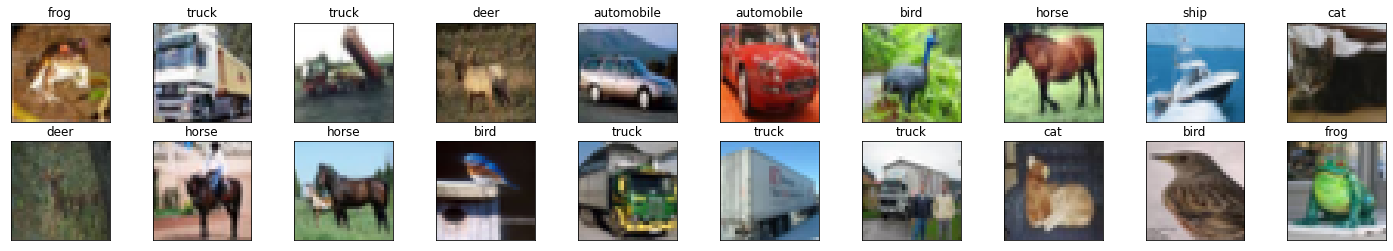

In [6]:
d = {0:"airplane", 1: "automobile", 2: "bird",
    3:"cat", 4:"deer", 5:"dog",
    6:"frog", 7:"horse", 8:"ship", 9:"truck"}

figure = plt.figure(figsize=(25,4))
for i in range(20):
    axis = figure.add_subplot(2, int(20/2), i+1, xticks=[], yticks=[])
    data = trainset.data[i]

    target = d[trainset.targets[i]]

    plt.imshow(data)
    axis.set_title(target)

## 3. Neural network architectures



1. FedAvg ***CNN*** for a total of 582.026 parameters with 28x28 input size. (Note: to get the number of parameters in the FedAvg paper: 1.663.370, the input image should be of size 40x40)




In [7]:
net = mnist_CNN()

summary(net, (1, 28,28))
# to get the paper "1,663,370 total parameters" image input size should be 40x40

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 24, 24]          832
├─MaxPool2d: 1-2                         [-1, 32, 12, 12]          --
├─Conv2d: 1-3                            [-1, 64, 8, 8]            51,264
├─MaxPool2d: 1-4                         [-1, 64, 4, 4]            --
├─Linear: 1-5                            [-1, 512]                 524,800
├─Linear: 1-6                            [-1, 10]                  5,130
Total params: 582,026
Trainable params: 582,026
Non-trainable params: 0
Total mult-adds (M): 4.27
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 2.22
Estimated Total Size (MB): 2.40


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 24, 24]          832
├─MaxPool2d: 1-2                         [-1, 32, 12, 12]          --
├─Conv2d: 1-3                            [-1, 64, 8, 8]            51,264
├─MaxPool2d: 1-4                         [-1, 64, 4, 4]            --
├─Linear: 1-5                            [-1, 512]                 524,800
├─Linear: 1-6                            [-1, 10]                  5,130
Total params: 582,026
Trainable params: 582,026
Non-trainable params: 0
Total mult-adds (M): 4.27
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 2.22
Estimated Total Size (MB): 2.40

In [8]:
net = cifar_CNN()
print(summary(net, (3, 32,32))) 

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 28, 28]          2,432
├─MaxPool2d: 1-2                         [-1, 32, 14, 14]          --
├─Conv2d: 1-3                            [-1, 64, 10, 10]          51,264
├─MaxPool2d: 1-4                         [-1, 64, 5, 5]            --
├─Linear: 1-5                            [-1, 512]                 819,712
├─Linear: 1-6                            [-1, 10]                  5,130
Total params: 878,538
Trainable params: 878,538
Non-trainable params: 0
Total mult-adds (M): 7.83
Input size (MB): 0.01
Forward/backward pass size (MB): 0.24
Params size (MB): 3.35
Estimated Total Size (MB): 3.61
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 28, 28]          2,432
├─MaxPool2d: 1-2                         [-1, 32, 14, 14]          --
├─Conv2d: 1-3                            [-1, 64, 10, 10]  

# 4. Federated Training

Coprises both:
* "Federated Averaging" https://arxiv.org/pdf/1602.05629.pdf, and 
* "Replicated Stochastic Gradient Descent" https://arxiv.org/pdf/2006.07897.pdf

For rSGD, instead of passing the central model back to the clients at each communication round, the aggregated parameters are passed to the clients, who in turn use them in the loss calculaion, by modifying it in:

$ w' = L(y, y^{hat}(x, \theta)) + \gamma ||w-w^{avg}||^2 $

where $L(y, y^{hat}(x, \theta))$ is a generic loss function between prediction and true value, and $ ||w-w^{agg}||^2 $ is the L2 distance of the client's parameters from the server's $w^{agg}$.

This way, the clients model gain persistence, and their results are anchored to the central model's parameters bia the prarameter $ \gamma $, who controls the incidence of the distance from the central model in the loss.

In [58]:
def training(algo, rounds, K, C, E, batch_size, optim, lr, gamma, gamma_scheduler, criterion, ds, iid, sha_client):
    """
    Function implements the Federated Averaging Algorithm from the FedAvg paper.
    Specifically, this function is used for the central server side training and weight update

    Params:
    - algo (string):                  either "fedavg" or "rsgd"
    - rounds (int):                   Number of communication rounds for the entire training
    - K (int):                        Total number of clients
    - C (float):                      Fraction of clients randomly chosen to perform computation on each round
    - E (int):                        Number of training passes each client makes over its local dataset per round
    - batch_size (int):               Batch size for client update training
    - lr (float):                     Learning rate used for client update training
    - gamma (float):                  cupling parameter for loss
    - gamma_scheduler (bool):         will use linear scheduler if true
    - criterion (torch.nn):           loss function to use (nn.CrossEntropyLoss)
    - ds (string):                    either "mnist", "fmnist", or "cifar10" 
    - iid (bool):                     Type of data partition to be used for training (IID or non-IID) 
    - sha_client (int):               Number of shards/max classes per client in case on non-iid

    Returns: prameters and metrics of the training
    """
    start = time.time() # measure time
    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    # retrieve datasets 
    train_ds, test_ds = get_dataset(ds)

    # use correct architecture
    if ds in ["mnist", "fmnist"]:        
        server_model = mnist_CNN().to(device)

    elif ds == "cifar10":            
        server_model = cifar_CNN().to(device)

    else: print("Not implemented!")
    

    round_train_loss, round_test_loss, round_acc = [], [], [] # store round training loss, test_loss and test accuracy
    round_rdist = [] # store distance of clients from barycenter
    round_hist = []      # every 50 rounds will store every model loss (to plot histogram)

    if gamma_scheduler == False:
        gamma = [gamma]*rounds
        
    elif gamma_scheduler == "lin":
        gamma = np.linspace(0.5, 5, rounds)

    elif gamma_scheduler == "geom":
        gamma = np.geomspace(0.5, 5, rounds)

    elif gamma_scheduler == "step":
        gamma = np.array(([0.5]*150) + ([1]*100) + ([2]*100) + ([5]*(rounds-350)))

    # clients models initialization and assign local datasets
    model_dict = {k:copy.deepcopy(server_model) for k in range(K)}
    data_dict = iid_partition(train_ds, K) if iid else non_iid_partition(train_ds, K, sha_client)

    # training federated model
    for comm_round in range(rounds):

        w, local_loss = [], []      # placeholders for clients' state_dict and losses
        m = max(int(C*K), 1)        # Number of partecipating clients (at least 1 client)
        S_t = np.random.choice(range(K), m, replace=False) # picking out set of partecipating clients

        for k in S_t:      

            # for fedavg the central model configuration is used in each round
            if algo =="fedavg":
                model_dict[k].load_state_dict(server_model.state_dict())

            local_update = ClientUpdate(algo            = algo,
                                        model           = model_dict[k], 
                                        dataset         = train_ds, 
                                        local_batchSize = batch_size, 
                                        optim           = optim,
                                        learning_rate   = lr * 0.995 ** comm_round, 
                                        gamma           = gamma[comm_round], # does not use gamma in fedavg, but class requires it
                                        criterion       = criterion,
                                        local_epochs    = E, 
                                        idxs            = data_dict[k],
                                        dev             = device)

            # Training of the client
            weights, loss = local_update.train(server_model) # server model only used by rsgd in coupling loss

            # saving client k last iteration weights and loss
            w.append(copy.deepcopy(weights))
            local_loss.append(copy.deepcopy(loss))
        loss_avg = sum(local_loss) / len(local_loss)               # averaging patecipating clients' losses

        # Averaging/aggregating client's models
        global_weights = server_aggregate(w) if C !=0 else w[0]    # in case of 1 client, it does not average               
        server_model.load_state_dict(global_weights)               # moving the updated weights to the model state dict  
        

        # evaluating central model performance
        test_loss, test_accuracy = test_metrics(model       = server_model,
                                                test_ds     = test_ds,
                                                criterion   = criterion,
                                                e_batchSize = 100)

        if (comm_round+1)%50 == 0 or comm_round == 0:
            h = []
            for k in range(K):
                local_eval = ClientEval(algo            = algo,
                                            model           = model_dict[k], 
                                            dataset         = train_ds, 
                                            local_batchSize = batch_size, 
                                            optim           = optim,
                                            learning_rate   = lr * 0.995 ** comm_round, 
                                            gamma           = gamma[comm_round], 
                                            criterion       = criterion,
                                            local_epochs    = E, 
                                            idxs            = data_dict[k],
                                            dev             = device)
                l = local_eval.eval(server_model)

                h.append(l)
            round_hist.append(h)

        # compute distance of partecipating clients from barycenter    
     
        r_dist = replicas_distance(global_weights, w)
        
        
        round_train_loss.append(loss_avg)
        round_test_loss.append(test_loss)
        round_acc.append(test_accuracy)
        round_rdist.append(r_dist.item())
        
        print("Round: {}\t| Average Loss: {}\t| Clients Dist: {}\t| Test Loss: {}\t| Test Accuracy: {:.2f}%".format(comm_round+1,
                                                                                                round(loss_avg, 5),
                                                                                                round(r_dist.item(),5),
                                                                                                round(test_loss, 5),
                                                                                                100*test_accuracy))
    print("Training done in: {}".format(str(timedelta(seconds = time.time()-start))))

    metrics = [{"train_loss" : round_train_loss, 
                "avg_dist":    round_rdist, 
                "test_loss" :  round_test_loss, 
                "test_acc" :   round_acc,
                "hist_loss":   round_hist}]


    outp = {"algo":           algo,
            "n_rounds":       rounds,
            "K":              K, 
            "C":              C,
            "dataset":        ds,
            "iid":            iid, 
            "sha_client":     10 if iid else sha_client ,
            "local_epochs":   E, 
            "local_batchSize":batch_size, 
            "optimizer":      optim,
            "learning_rate":  lr,
            "metrics":        metrics,
            "gamma":          gamma[0],
            "g_sceduler":     gamma_scheduler}

    return outp

In [70]:
# Test run [0.1, 5]
res = training(
    algo            = "rsgd",
    rounds          = 500,
    K               = 100,
    C               = 0.1,
    E               = 5,
    batch_size      = 50,
    optim           = "sgd",
    lr              = 0.1,
    gamma           = 5,
    gamma_scheduler = "step",
    criterion       = nn.CrossEntropyLoss(),
    ds              = "cifar10", 
    iid             = False,
    sha_client      = 2
)

df = pd.DataFrame(res)
df

Files already downloaded and verified
Files already downloaded and verified
Round: 1	| Average Loss: 0.02623	| Clients Dist: 4.36445	| Test Loss: 0.02303	| Test Accuracy: 11.39%
Round: 2	| Average Loss: 0.0339	| Clients Dist: 5.04628	| Test Loss: 0.02311	| Test Accuracy: 10.00%
Round: 3	| Average Loss: 0.02978	| Clients Dist: 4.1625	| Test Loss: 0.02308	| Test Accuracy: 13.60%
Round: 4	| Average Loss: 0.02635	| Clients Dist: 4.37978	| Test Loss: 0.0233	| Test Accuracy: 10.10%
Round: 5	| Average Loss: 0.02672	| Clients Dist: 4.15932	| Test Loss: 0.02304	| Test Accuracy: 14.89%
Round: 6	| Average Loss: 0.03107	| Clients Dist: 4.63112	| Test Loss: 0.02236	| Test Accuracy: 16.81%
Round: 7	| Average Loss: 0.02775	| Clients Dist: 4.04938	| Test Loss: 0.02258	| Test Accuracy: 15.41%
Round: 8	| Average Loss: 0.0272	| Clients Dist: 4.25225	| Test Loss: 0.0217	| Test Accuracy: 22.64%
Round: 9	| Average Loss: 0.0287	| Clients Dist: 4.1565	| Test Loss: 0.02202	| Test Accuracy: 17.36%
Round: 10	| A

,algo,n_rounds,K,C,dataset,iid,sha_client,local_epochs,local_batchSize,optimizer,learning_rate,metrics,gamma,g_sceduler
0,rsgd,500,100,0.1,cifar10,False,2,5,50,sgd,0.1,"{'train_loss': [0.026231190742850307, 0.033904...",0.5,step


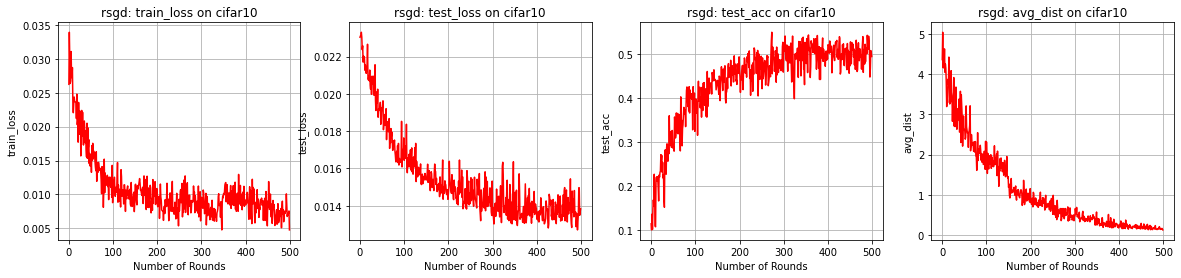

In [71]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=False)
fig.set_size_inches(20, 4)

for ax, metr in zip((ax1, ax2, ax3, ax4), ["train_loss", "test_loss", "test_acc", "avg_dist"]):
    m = df.metrics.item()[metr]    
    x = np.arange(len(m))
    ax.plot(x, m, color = "red", linestyle = '-')
    ax.set(xlabel='Number of Rounds', ylabel=f'{metr}', title = f"{df.algo.item()}: {metr} on {df.dataset.item()}")
    ax.grid()

In [72]:
sched1 = df
sched1.to_csv("logs/log_rfed_sched_geomspace.csv", mode = 'a', header=False)

# 5 FedAvg TESTS

## 5.1 Test 1

Output:
* number of communication rounds to achieve 9X% accuracy with a CNN on FashionMNIST dataset for both iid and non-iid case under different hyperparam configurations of partecipating clients and local batch size

Fixed parameters:
* local epochs = 5
* Total clients = 100
* Learning Rate = 0.001

Varying parameters:
* C = [0, .1, .2, .5 ,1] 
* Batch size = [10, 'all'] 


In [25]:
i = 0
for iid in [True, False]:
    for c in [0, 0.1, 0.2, 0.5, 1]: 
        for bs in [10, "all"]:

            print("\nIID:", iid, "C: ",c, "BS: ",bs, "\n")
            res = training(
                    algo            = "fedavg",
                    rounds          = 250,
                    K               = 100,
                    C               = c,
                    E               = 5,
                    batch_size      = bs,
                    optim           = "sgd",
                    lr              = 0.1,
                    gamma           = 0.01,
                    gamma_scheduler = False,
                    criterion       = nn.CrossEntropyLoss(),
                    ds              = "fmnist", 
                    iid             = iid,
                    sha_client      = 2
                )

            df = pd.DataFrame(res)

            if i == 0: 
                df.to_csv("logs/log_fedavg_t1.csv")
                i+=1
            else: 
                df.to_csv("logs/log_fedavg_t1.csv", mode = 'a', header=False)


IID: True C:  0 BS:  10 

Round: 1	| Average Loss: 0.09859	| Clients Dist: 0.0	| Test Loss: 0.00821	| Test Accuracy: 71.11%
Round: 2	| Average Loss: 0.04962	| Clients Dist: 0.0	| Test Loss: 0.00798	| Test Accuracy: 73.92%
Round: 3	| Average Loss: 0.04403	| Clients Dist: 0.0	| Test Loss: 0.00685	| Test Accuracy: 79.52%
Round: 4	| Average Loss: 0.04362	| Clients Dist: 0.0	| Test Loss: 0.00526	| Test Accuracy: 81.24%
Round: 5	| Average Loss: 0.02906	| Clients Dist: 0.0	| Test Loss: 0.00732	| Test Accuracy: 81.50%
Round: 6	| Average Loss: 0.03043	| Clients Dist: 0.0	| Test Loss: 0.00616	| Test Accuracy: 82.48%
Round: 7	| Average Loss: 0.03138	| Clients Dist: 0.0	| Test Loss: 0.00585	| Test Accuracy: 83.11%
Round: 8	| Average Loss: 0.02655	| Clients Dist: 0.0	| Test Loss: 0.00611	| Test Accuracy: 83.02%
Round: 9	| Average Loss: 0.02653	| Clients Dist: 0.0	| Test Loss: 0.00659	| Test Accuracy: 82.34%
Round: 10	| Average Loss: 0.02211	| Clients Dist: 0.0	| Test Loss: 0.00678	| Test Accuracy:

## 5.2 Test 2

Output:
* the number of communication rounds needed to reach 9X% accuracy with a CNN on FashionMNIST dataset for both iid and non-iid case for different hyperparams.

Fixed parameters:
* Client fraction = 0.1 (10 clients partecipate each round)
* Total clients = 100
* Learning Rate = 0.001

Varying parameters:
* Local epochs = [1, 5, 20] 
* Batch size = [10, 50, 'all'] 



In [82]:
i=0
for iid in [True, False]:
    for e in [5, 1]:
        for bs in ["all"]:

            print("\nIID: ", iid, "E: ",e, "BS: ",bs)
            res = training(
                    algo            = "fedavg",
                    rounds          = 500,
                    K               = 100,
                    C               = 0.1,
                    E               = e,
                    batch_size      = bs,
                    optim           = "sgd",
                    lr              = 0.1,
                    gamma           = 0.01,
                    gamma_scheduler = False,
                    criterion       = nn.CrossEntropyLoss(),
                    ds              = "fmnist", 
                    iid             = iid,
                    sha_client      = 2
                )

            df = pd.DataFrame(res)

            if i == 0: 
                df.to_csv("logs/log_fedavg_t2.csv")
                i+=1
            else: 
                df.to_csv("logs/log_fedavg_t2.csv", mode = 'a', header=False)


IID:  True E:  5 BS:  all
Round: 1	| Average Loss: 0.00368	| Clients Dist: 0.07102	| Test Loss: 0.02007	| Test Accuracy: 46.48%
Round: 2	| Average Loss: 0.00353	| Clients Dist: 4.95472	| Test Loss: 0.02147	| Test Accuracy: 40.10%
Round: 3	| Average Loss: 0.00306	| Clients Dist: 0.05429	| Test Loss: 0.01307	| Test Accuracy: 61.44%
Round: 4	| Average Loss: 0.00298	| Clients Dist: 6.32319	| Test Loss: 0.01971	| Test Accuracy: 46.77%
Round: 5	| Average Loss: 0.00248	| Clients Dist: 0.05901	| Test Loss: 0.01005	| Test Accuracy: 66.82%
Round: 6	| Average Loss: 0.00268	| Clients Dist: 1.91183	| Test Loss: 0.01513	| Test Accuracy: 46.00%
Round: 7	| Average Loss: 0.00207	| Clients Dist: 0.06714	| Test Loss: 0.0093	| Test Accuracy: 69.17%
Round: 8	| Average Loss: 0.00197	| Clients Dist: 0.71504	| Test Loss: 0.0102	| Test Accuracy: 64.80%
Round: 9	| Average Loss: 0.00148	| Clients Dist: 0.18684	| Test Loss: 0.01161	| Test Accuracy: 57.49%
Round: 10	| Average Loss: 0.00167	| Clients Dist: 0.13274

In [27]:
for iid in [True, False]:
    for e in [1, 5, 20]:
        for bs in [10, 50, "all"]:

            print("\nIID: ", iid, "E: ",e, "BS: ",bs)
            res = training(
                    algo            = "fedavg",
                    rounds          = 250,
                    K               = 100,
                    C               = 0.1,
                    E               = e,
                    batch_size      = bs,
                    optim           = "sgd",
                    lr              = 0.1,
                    gamma           = 0.01,
                    gamma_scheduler = False,
                    criterion       = nn.CrossEntropyLoss(),
                    ds              = "fmnist", 
                    iid             = iid,
                    sha_client      = 2
                )

            df = pd.DataFrame(res)

        
            df.to_csv("logs/log_fedavg_t2.csv", mode = 'a', header=False)


IID:  True E:  20 BS:  10
Round: 1	| Average Loss: 0.04149	| Clients Dist: 544.48108	| Test Loss: 0.00584	| Test Accuracy: 79.27%
Round: 2	| Average Loss: 0.01343	| Clients Dist: 220.64799	| Test Loss: 0.00708	| Test Accuracy: 84.61%
Round: 3	| Average Loss: 0.00988	| Clients Dist: 198.51672	| Test Loss: 0.0066	| Test Accuracy: 85.70%
Round: 4	| Average Loss: 0.00799	| Clients Dist: 188.24794	| Test Loss: 0.00617	| Test Accuracy: 86.22%
Round: 5	| Average Loss: 0.00697	| Clients Dist: 166.94974	| Test Loss: 0.00603	| Test Accuracy: 86.78%
Round: 6	| Average Loss: 0.0062	| Clients Dist: 150.93726	| Test Loss: 0.00572	| Test Accuracy: 87.20%
Round: 7	| Average Loss: 0.00552	| Clients Dist: 142.51578	| Test Loss: 0.00553	| Test Accuracy: 87.48%
Round: 8	| Average Loss: 0.00497	| Clients Dist: 139.00394	| Test Loss: 0.00532	| Test Accuracy: 87.50%
Round: 9	| Average Loss: 0.005	| Clients Dist: 135.69466	| Test Loss: 0.00518	| Test Accuracy: 87.57%
Round: 10	| Average Loss: 0.00454	| Clien

# 6 rSGD - federated TESTS

## 6.0 Test 0

Output: 
* identify a suitable range of gamma to generate scheduler by analyzing result on both FashionMNIST and CIFAR10(?) dataset (hoping the range coincides)
* plot curves and avg distance between replicas

Fixed Params:
* all of fedAvg

Varying params:
* iid = [True, False]
* gamma = [.001,.005, .01, .05, .1, .5, 1, 5]

In [74]:
i = 0
for iid in [True]:
    for c in [.2, .5]:
        res = training(
            algo            = "rsgd",
            rounds          = 500,
            K               = 100,
            C               = c,
            E               = 5,
            batch_size      = 50,
            optim           = "sgd",
            lr              = 0.1,
            gamma           = 0.5,
            gamma_scheduler = "step",
            criterion       = nn.CrossEntropyLoss(),
            ds              = "cifar10", 
            iid             = iid,
            sha_client      = 2
        )

        df = pd.DataFrame(res)
        if i == 0:
            df.to_csv("logs/log_rfed_moreC.csv")
            i+=1
        else:
            df.to_csv("logs/log_rfed_moreC.csv", mode = 'a', header=False)

Files already downloaded and verified
Files already downloaded and verified
Round: 1	| Average Loss: 0.04573	| Clients Dist: 1.10072	| Test Loss: 0.02169	| Test Accuracy: 24.08%
Round: 2	| Average Loss: 0.04429	| Clients Dist: 1.11866	| Test Loss: 0.02077	| Test Accuracy: 28.29%
Round: 3	| Average Loss: 0.04336	| Clients Dist: 1.31505	| Test Loss: 0.02017	| Test Accuracy: 29.35%
Round: 4	| Average Loss: 0.04307	| Clients Dist: 1.52827	| Test Loss: 0.01978	| Test Accuracy: 30.45%
Round: 5	| Average Loss: 0.04244	| Clients Dist: 1.38881	| Test Loss: 0.01925	| Test Accuracy: 31.20%
Round: 6	| Average Loss: 0.04178	| Clients Dist: 1.6522	| Test Loss: 0.01898	| Test Accuracy: 33.66%
Round: 7	| Average Loss: 0.04147	| Clients Dist: 1.74107	| Test Loss: 0.01869	| Test Accuracy: 34.45%
Round: 8	| Average Loss: 0.04115	| Clients Dist: 1.7778	| Test Loss: 0.01831	| Test Accuracy: 35.35%
Round: 9	| Average Loss: 0.0406	| Clients Dist: 1.81426	| Test Loss: 0.01798	| Test Accuracy: 36.55%
Round: 10

In [90]:
df2 = pd.read_csv("logs/log_rfed_sched_geomspace.csv")
#df = df[(df["gamma"] != 10) & (df["gamma"] != 100)]
df2["metrics"] = df2["metrics"].apply(lambda x: json.loads(x.replace("'", "\"")))

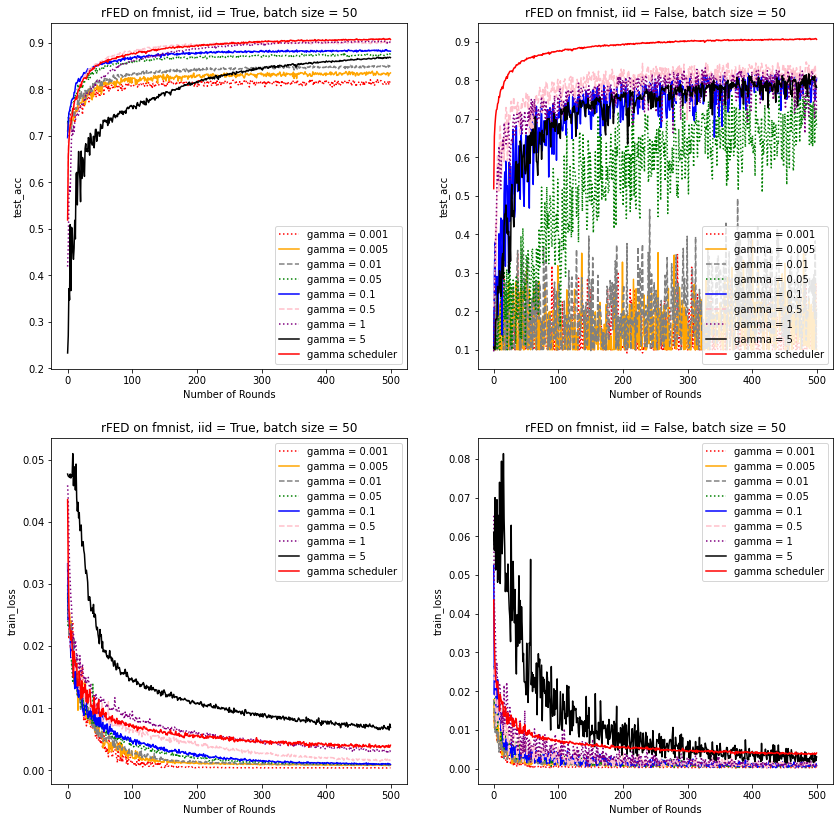

In [34]:
df = pd.read_csv("logs/log_rfed_sched.csv")
df = df[(df["gamma"] != 10) & (df["gamma"] != 100)]
df["metrics"] = df["metrics"].apply(lambda x: json.loads(x.replace("'", "\"")))
#type(df[(df["dataset"] == "cifar10") & (df["gamma"] == 0.01)]["metrics"].item())

color_dict = {0:"red", 1:"orange", 2:"grey", 3:"green", 4:"blue", 5:"pink", 6:"purple", 7:"black"}
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharey = False)
fig.set_size_inches(20, 20)


ds = "fmnist"

for ax_pair, metr in zip(((ax1, ax2),(ax3, ax4)), ["test_acc", "avg_dist"]):
    for ax, iid in zip(ax_pair, [True, False]):
        for col, (dash, gamma) in enumerate(zip([":", "-","--", ":", "-","--", ":", "-"], [.001,.005, .01, .05, .1, .5, 1, 5])):

            acc = df[(df["dataset"] == ds) & (df["iid"]==iid) & (df["gamma"]==gamma) & (df["g_sceduler"]==False)]["metrics"].item()[metr]

            x = np.arange(len(acc))
            ax.plot(x, acc, color = "grey", linestyle = dash, label = "gamma = {}  ".format(gamma))
            ax.set(xlabel='Number of Rounds', ylabel=f'{metr}', title = f"rSGD on {ds}, IID = {iid}")
            #ax.set_ylim([0.1, 1]) if metr =="test_acc" else  ax.set_ylim([0, 0.025])
            ax.grid()
        #acc2 = df2[(df2["dataset"] == ds) & (df2["iid"]==iid) & (df2["g_sceduler"]=="geom")]["metrics"].item()[metr]
        acc3 = df2[(df2["dataset"] == ds) & (df2["iid"]==iid) & (df2["g_sceduler"]=="step")]["metrics"].item()[metr]
        #acc4 = df2[(df2["dataset"] == ds) & (df2["iid"]==iid) & (df2["g_sceduler"]=="lin")]["metrics"].item()[metr]
        #ax.plot(x, acc2, color = "C0", linestyle = "-", label = "gamma = geometrical scheduler ")
        ax.plot(x, acc3, color = "r", linestyle = "-", label = "gamma = step scheduler ")
        #ax.plot(x, acc4, color = "C1", linestyle = "-", label = "gamma = linear scheduler ")
        ax.legend(loc = "lower right") if metr == "test_acc" else ax.legend(loc = "upper right")

In [106]:
color_dict = {0:"red", 1:"orange", 2:"grey", 3:"green", 4:"blue", 5:"pink", 6:"purple", 7:"black"}
ds = "cifar10"

hists = df2[(df2["dataset"] == ds) & 
            (df2["iid"]==False) & 
            (df2["g_sceduler"]=="step")]["metrics"].item()["hist_loss"]

plt.figure(figsize=(8, 6), dpi=80)
bins = np.linspace(0, 0.055, 100)

#plt.hist(hists[0], bins, alpha=0.5, label='round 1')
plt.hist(hists[1], bins, alpha=0.5, label='round 50')
plt.hist(hists[2], bins, alpha=0.5, label='round 100')
plt.hist(hists[3], bins, alpha=0.5, label='round 150')
plt.hist(hists[5], bins, alpha=0.5, label='round 250')
plt.hist(hists[-1], bins, alpha=0.5, label='round 500')

plt.title("Clients loss histograms for non-IID scenario with stepwise scheduler")
plt.legend(loc='upper right')
plt.show()

In [ ]:
ds = "fmnist" 
for iid in [True, False]:
    print("IID" if iid else "non-IID")
    for g in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5]:
        acc = df[(df["dataset"] == ds) & 
                    (df["iid"]==iid) & 
                    (df["g_sceduler"]==False)& 
                    (df["gamma"]==g)]["metrics"].item()["test_acc"]

        print(f"Gamma = {g}\t --> Communication round: {np.argmax(np.array(acc))} Best Accuracy: {np.max(np.array(acc))}, Last round accuracy: {np.array(acc)[-1]}")
    acc = df2[(df2["dataset"] == ds) & 
                    (df2["iid"]==iid) & 
                    (df2["g_sceduler"]=="step")]["metrics"].item()["test_acc"]
    print (f"Gamma = sched\t --> Communication round: {np.argmax(np.array(acc))} Best Accuracy: {np.max(np.array(acc))}, Last round accuracy: {np.array(acc)[-1]}")

In [ ]:
# Schedulers - plot of gamma evolution
fig, ax = plt.subplots()
ax.plot(np.geomspace(.5, 5, 500), label = "geometrical")
ax.plot(np.linspace(.5, 5, 500), label = "linear")
ax.plot(np.array(([0.5]*150)+ ([1]*100) + ([2]*100) + ([5]*150)), label = "step")
ax.legend(loc = "lower right")
ax.grid()
ax.set_ylabel("gamma")
ax.set_xlabel("round")
plt.ylim(0,5.5)
plt.show()

In [ ]:
# Direct comparison
df = pd.read_csv("logs/log_compare_t1.csv")
df["metrics"] = df["metrics"].apply(lambda x: json.loads(x.replace("'", "\"")))

df = df.append(df2)

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharey = False)
fig.set_size_inches(14, 14)

color_dict = {0:"red", 1:"orange", 2:"grey", 3:"green", 4:"blue", 5:"purple", 6:"black"}
ds = "cifar10"

for ax_pair, metr in zip(((ax1, ax2),(ax3, ax4)), ["test_acc", "test_loss"]):
    for ax, iid in zip(ax_pair, [True, False]):
        

        acc = df[(df["algo"] == "fedavg") &
                    (df["dataset"] == ds) & 
                    (df["iid"]==iid)]["metrics"].item()[metr]
        
        acc2 = df[(df["algo"] == "rsgd") &
                    (df["dataset"] == ds) & 
                    (df["iid"]==iid) & (df["g_sceduler"]=="step")]["metrics"].item()[metr]

        x = np.arange(len(acc))
        ax.plot(x, acc, color = "C0", linestyle = dash, label = "Algorithm = FedAvg")
        ax.plot(x, acc2, color = "r", linestyle = dash, label = "Algorithm = r-SGD")
        ax.set(xlabel='Number of Rounds', ylabel=f'{metr}', title = f"CIFAR10, IID = {iid}")
        ax.set_ylim([0.2, 1]) if metr =="test_acc" else  ax.set_ylim([0, 0.025])
        ax.grid()
    ax.legend(loc = "lower right") if metr == "test_acc" else ax.legend(loc = "upper right")


## Direct Comparison

testing the model with the best gamma range identified from previous test

In [18]:
i = 0
for iid in [True, False]:
    for ds in ["fmnist", "cifar10"]:
        for algo in ["fedavg", "rsgd"]:
            res = training(
                algo            = algo,
                rounds          = 500,
                K               = 100,
                C               = 0.1,
                E               = 5,
                batch_size      = 50,
                optim           = "sgd",
                lr              = 0.1,
                gamma           = 0.1,
                gamma_scheduler = True,
                criterion       = nn.CrossEntropyLoss(),
                ds              = ds, 
                iid             = iid,
                sha_client      = 2
            )

            df = pd.DataFrame(res)
            if i == 0: 
                df.to_csv("logs/log_compare_t1.csv")
                i+=1
            else: 
                df.to_csv("logs/log_compare_t1.csv", mode = 'a', header=False)

Round: 1	| Average Loss: 0.02865	| Clients Dist: 23.91312	| Test Loss: 0.00918	| Test Accuracy: 71.45%
Round: 2	| Average Loss: 0.01477	| Clients Dist: 6.18322	| Test Loss: 0.00637	| Test Accuracy: 75.43%
Round: 3	| Average Loss: 0.0121	| Clients Dist: 6.34471	| Test Loss: 0.00569	| Test Accuracy: 78.11%
Round: 4	| Average Loss: 0.01103	| Clients Dist: 7.5064	| Test Loss: 0.00517	| Test Accuracy: 80.70%
Round: 5	| Average Loss: 0.00973	| Clients Dist: 7.78642	| Test Loss: 0.00495	| Test Accuracy: 81.51%
Round: 6	| Average Loss: 0.00903	| Clients Dist: 8.42473	| Test Loss: 0.00463	| Test Accuracy: 82.97%
Round: 7	| Average Loss: 0.00814	| Clients Dist: 8.57009	| Test Loss: 0.00438	| Test Accuracy: 84.27%
Round: 8	| Average Loss: 0.00725	| Clients Dist: 8.83836	| Test Loss: 0.00428	| Test Accuracy: 85.01%
Round: 9	| Average Loss: 0.00675	| Clients Dist: 9.10172	| Test Loss: 0.00417	| Test Accuracy: 85.45%
Round: 10	| Average Loss: 0.00654	| Clients Dist: 9.30992	| Test Loss: 0.00405	| Te

In [ ]:
i = 0
for ds in ["fmnist", "cifar10"]:
    for iid in [False, True]:
        res = training(
            algo            = "rsgd",
            rounds          = 500,
            K               = 100,
            C               = 0.1,
            E               = 5,
            batch_size      = 50,
            optim           = "sgd",
            lr              = 0.1,
            gamma           = 0.5,
            gamma_scheduler = "lin",
            criterion       = nn.CrossEntropyLoss(),
            ds              = ds, 
            iid             = iid,
            sha_client      = 2
        )

        df = pd.DataFrame(res)
        df.to_csv("logs/log_rfed_sched_geomspace.csv", mode = 'a', header=False)

# 7. Comparisons

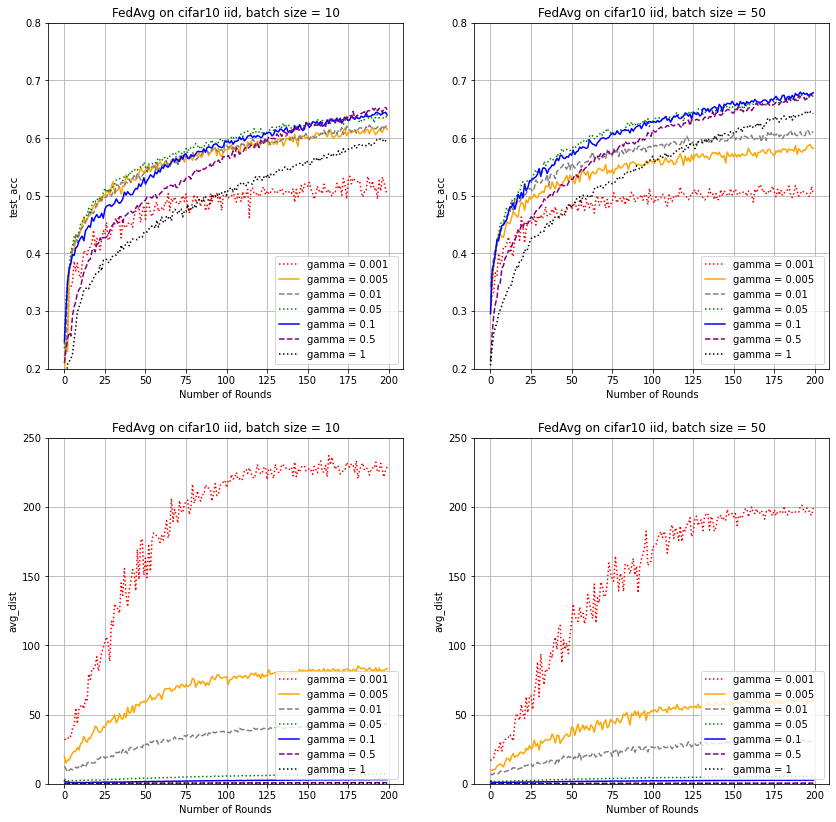

In [26]:
df = pd.read_csv("logs/log_rfed_cifar.csv")
df["metrics"] = df["metrics"].apply(lambda x: json.loads(x.replace("'", "\"")))
type(df[(df["dataset"] == "cifar10") & (df["gamma"] == 0.01)]["metrics"].item())

df2 = pd.read_csv("logs/log_rfed_cifar_bs50.csv")
df2["metrics"] = df2["metrics"].apply(lambda x: json.loads(x.replace("'", "\"")))

df = df.append(df2)

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharey = False)
fig.set_size_inches(14, 14)

color_dict = {0:"red", 1:"orange", 2:"grey", 3:"green", 4:"blue", 5:"purple", 6:"black"}
ds = "cifar10"

for ax_pair, metr in zip(((ax1, ax2),(ax3, ax4)), ["test_acc", "avg_dist"]):
    for ax, bs in zip(ax_pair, [10, 50]):
        for col, (dash, gamma) in enumerate(zip([":", "-","--", ":", "-","--", ":"], [.001,.005, .01, .05, .1, .5, 1])):

            acc = df[(df["dataset"] == ds) & 
                       (df["local_batchSize"]==bs) & 
                       (df["gamma"]==gamma)]["metrics"].item()[metr]

            x = np.arange(len(acc))
            ax.plot(x, acc, color = color_dict[col], linestyle = dash, label = "gamma = {}  ".format(gamma))
            ax.set(xlabel='Number of Rounds', ylabel=f'{metr}', title = "FedAvg on {} iid, batch size = {}".format(ds, bs))
            ax.set_ylim([0.2, 0.8]) if metr =="test_acc" else  ax.set_ylim([0, 250])
            ax.grid()
        ax.legend(loc = "lower right")


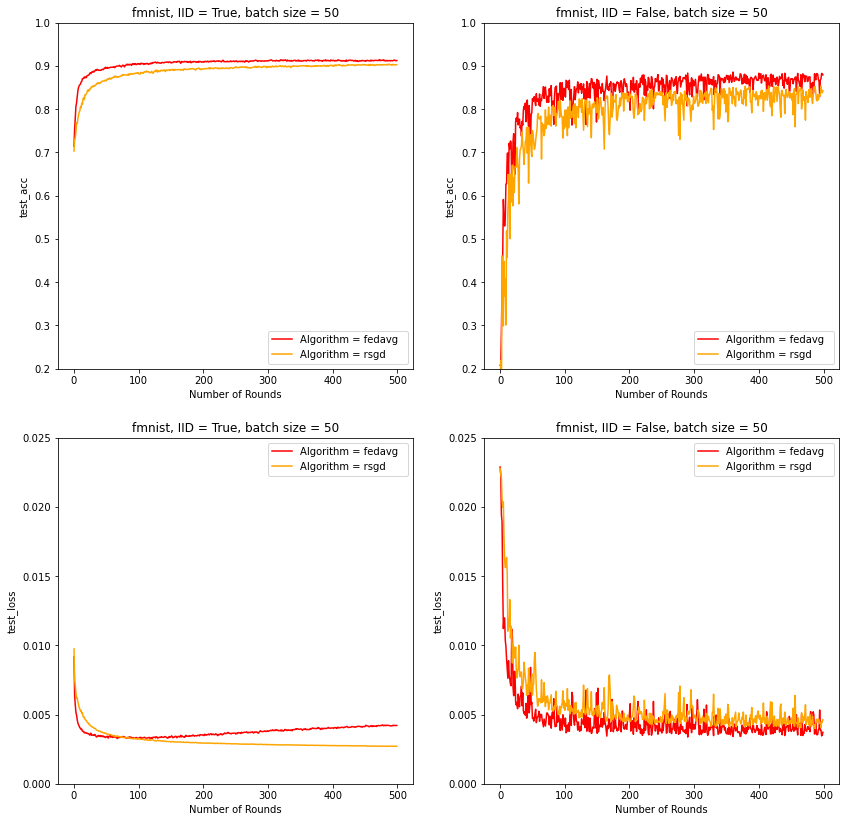

In [39]:
df = pd.read_csv("logs/log_compare_t1.csv")
df["metrics"] = df["metrics"].apply(lambda x: json.loads(x.replace("'", "\"")))
#type(df[(df["dataset"] == "cifar10") & (df["gamma"] == 0.01)]["metrics"].item())

color_dict = {0:"red", 1:"orange", 2:"grey", 3:"green", 4:"blue", 5:"purple", 6:"black"}
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharey = False)
fig.set_size_inches(14, 14)


ds = "fmnist"

for ax_pair, metr in zip(((ax1, ax2),(ax3, ax4)), ["test_acc", "test_loss"]):
    for ax, iid in zip(ax_pair, [True, False]):
        for col, algo in enumerate(["fedavg", "rsgd"]):

            acc = df[(df["algo"] == algo) &
                        (df["dataset"] == ds) & 
                        (df["iid"]==iid)]["metrics"].item()[metr]

            x = np.arange(len(acc))
            ax.plot(x, acc, color = color_dict[col], linestyle = dash, label = "Algorithm = {}  ".format(algo))
            ax.set(xlabel='Number of Rounds', ylabel=f'{metr}', title = f"{ds}, IID = {iid}, batch size = {50}")
            ax.set_ylim([0.2, 1]) if metr =="test_acc" else  ax.set_ylim([0, 0.025])
            ax.grid()
        ax.legend(loc = "lower right") if metr == "test_acc" else ax.legend(loc = "upper right")


## OLD Test 6.5

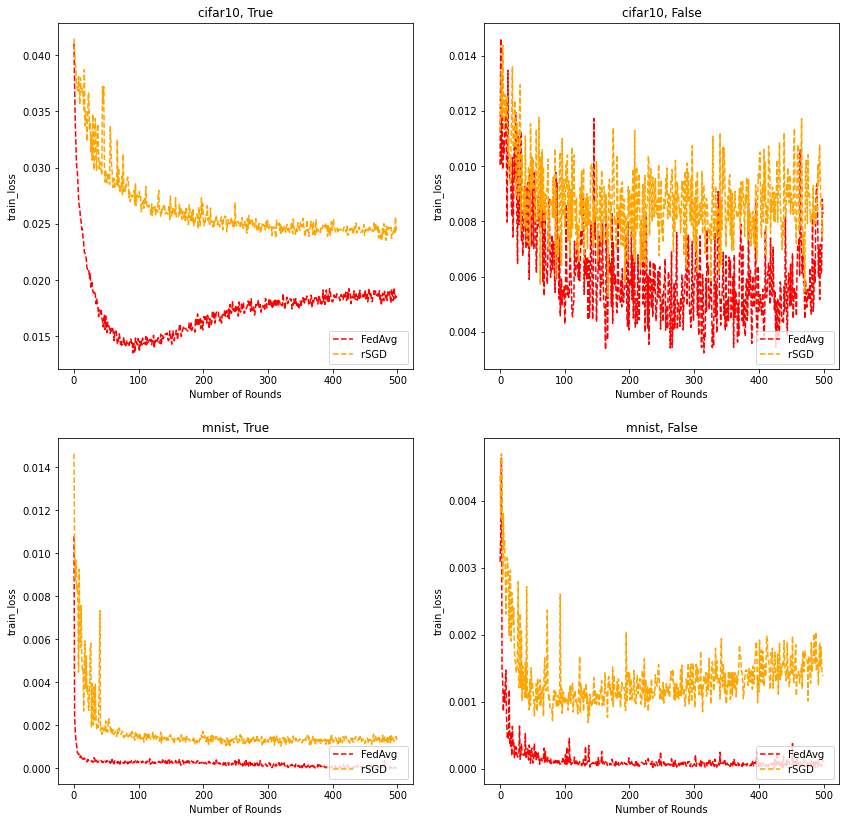

In [84]:
t05 = pd.read_csv("logs/log_t05.csv")
t05["metrics"] = t05["metrics"].apply(lambda x: json.loads(x.replace("'", "\"")))
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharey = False)
fig.set_size_inches(14, 14)

color_dict = {0:"red", 1:"orange", 2:"grey", 3:"green", 4:"blue", 5:"purple", 6:"black"}
ds = "mnist"

for ax_pair, ds in zip(((ax1, ax2),(ax3, ax4)), ["cifar10", "mnist"]):
    for ax, iid in zip(ax_pair, [True, False]):
        for col, algo in enumerate(["FedAvg", "rSGD"]):

            acc = t05[(t05["dataset"] == ds) & 
                       (t05["iid"]==iid) & 
                       (t05["algo"]==algo)]["metrics"].item()["train_loss"]

            x = np.arange(len(acc))
            ax.plot(x, acc, color = color_dict[col], linestyle = "--", label = "{}  ".format(algo))
            ax.set(xlabel='Number of Rounds', ylabel=f'{metr}', title = "{}, {}".format(ds, iid))
            #ax.set_ylim([0.85, 1]) if ds =="mnist" else  ax.set_ylim([0.1, .8])
            ax.grid()
        ax.legend(loc = "lower right")

## 7.1 FedAvg Test 1

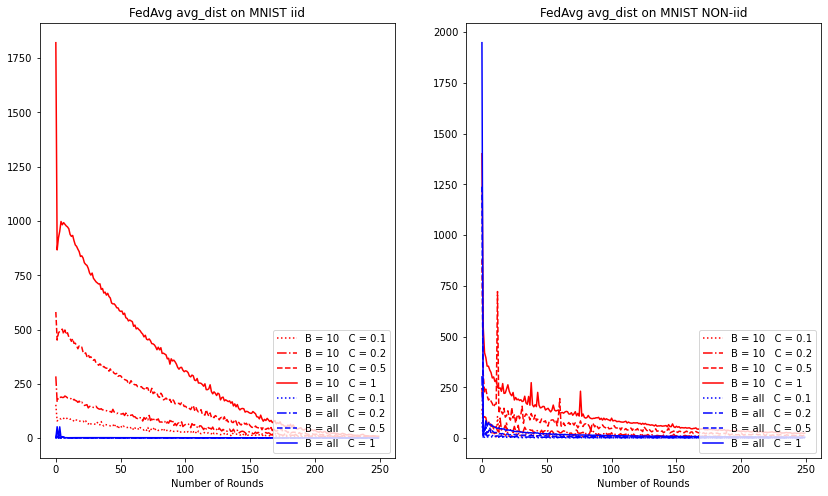

In [132]:
fedavg_t1 = pd.read_csv("logs/log_fedavg_t1.csv")
fedavg_t1["metrics"] = fedavg_t1["metrics"].apply(lambda x: json.loads(x.replace("'", "\"")))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey = False)
fig.set_size_inches(14, 8)

metr = "train_loss"

for ax, iid in zip([ax1, ax2], [True, False]):
    for color, bs in zip(["red", "blue"],["10", "all"]):
        for dash, c in zip([":", "-.","--", "-"], [0.1, 0.2, 0.5, 1]):

            acc = fedavg_t1[(fedavg_t1["C"] == c) & 
                       (fedavg_t1["local_batchSize"]==bs) & 
                       (fedavg_t1["iid"]==iid)]["metrics"].item()[metr]

            x = np.arange(len(acc))
            ax.plot(x, acc, color = color, linestyle = dash, label = "B = {}   C = {}".format(bs, c))
            ax.set(xlabel='Number of Rounds', ylabel='Accuracy', title = "FedAvg on Fashion-MNIST, {} partition ".format("IID" if iid else "non-IID"))
            #ax.set_ylim(0.5, 1)
            ax.grid()
        ax.legend(loc = "lower right")


## 7.2 FedAvg Test 2

### FedAvg

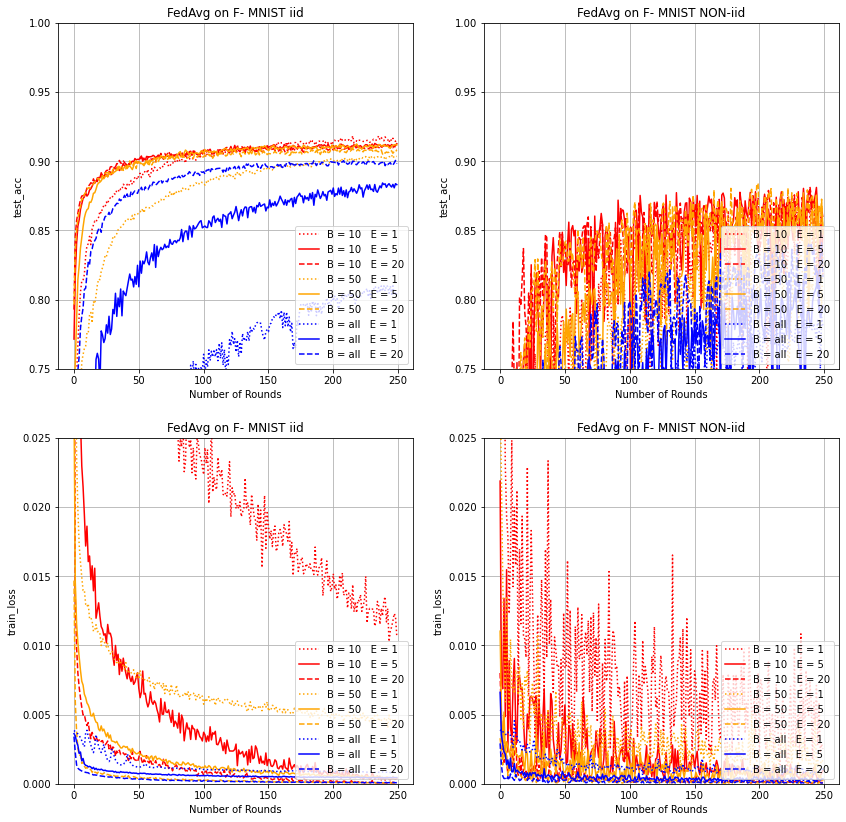

In [34]:
fedavg_t2 = pd.read_csv("logs/log_fedavg_t2.csv")
fedavg_t2["metrics"] = fedavg_t2["metrics"].apply(lambda x: json.loads(x.replace("'", "\"")))

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharey = False)
fig.set_size_inches(14, 14)

color_dict = {0:"red", 1:"orange", 2:"blue", 3:"green", 4:"blue", 5:"purple", 6:"black"}
#ds = "cifar10"

for ax_pair, metr in zip(((ax1, ax2),(ax3, ax4)), ["test_acc", "train_loss"]):
    for ax, iid in zip(ax_pair, [True, False]):
        for color, bs in enumerate(["10", "50", "all"]):
            for dash, e in zip([":", "-","--"], [1, 5, 20]):

                acc = fedavg_t2[(fedavg_t2["local_epochs"] == e) & 
                           (fedavg_t2["local_batchSize"]==bs) & 
                           (fedavg_t2["iid"]==iid) & 
                           (fedavg_t2["dataset"]=="fmnist")]["metrics"].item()[metr]

                x = np.arange(len(acc))
                ax.plot(x, acc, color = color_dict[color], linestyle = dash, label = "B = {}   E = {}".format(bs, e))
                ax.set(xlabel='Number of Rounds', ylabel=metr , title = "FedAvg on F- MNIST {}".format("iid" if iid else "NON-iid"))
                ax.set_ylim(.75, 1) if metr == "test_acc" else ax.set_ylim(0, .025)
                ax.grid()
            ax.legend(loc = "lower right")


### OLDER results / Test Zone (r-SGD)

In [120]:
rfed  = pd.read_csv("log_rfed_t2.csv")
rfed["metrics"] = rfed["metrics"].apply(lambda x: ast.literal_eval(x))
print (type((rfed[(rfed["local_epochs"] == 1) & (rfed["local_batchSize"] == "10") & (rfed["iid"] == True) & (rfed["gamma"] == 0.05)]["metrics"].item())))

<class 'dict'>


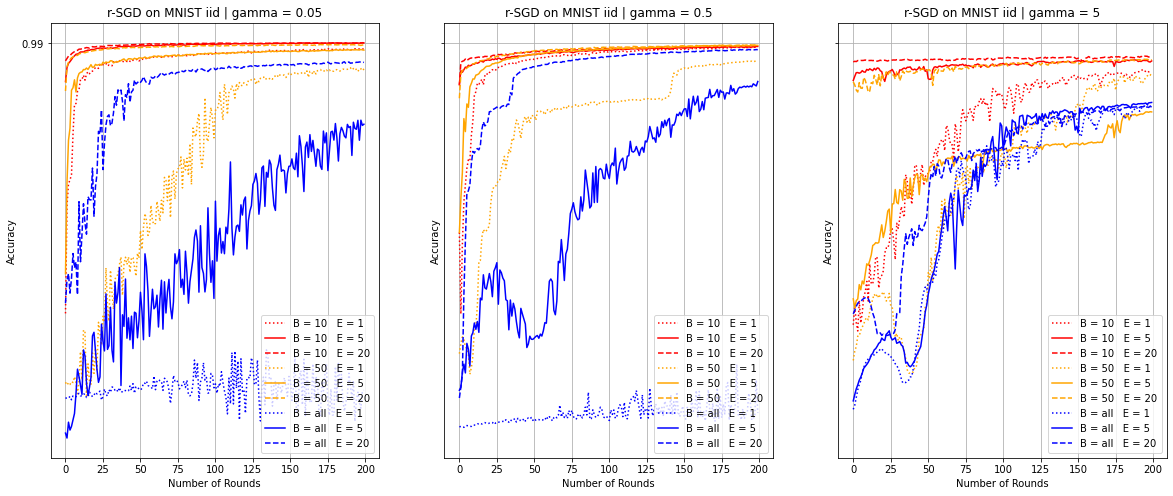

In [170]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True)
fig.set_size_inches(20, 8)

for ax, gamma in zip([ax1, ax2, ax3], [0.05, 0.5, 5]):
    for color, bs in zip(["red", "orange", "blue"],["10", "50", "all"]):
        for dash, e in zip([":", "-","--"], [1, 5, 20]):

            acc = rfed[(rfed["local_epochs"] == e) & 
                       (rfed["local_batchSize"]==bs) & 
                       (rfed["gamma"]==gamma) &
                       (rfed["iid"]==True)]["metrics"].item()["test_acc"]

            x = np.arange(len(acc))
            ax.plot(x, acc, color = color, linestyle = dash, label = "B = {}   E = {}".format(bs, e))
            ax.set(xlabel='Number of Rounds', ylabel='Accuracy', title = "r-SGD on MNIST iid | gamma = {}".format(gamma))
            ax.set_yticks([.99])
            ax.grid()
        ax.legend(loc = "lower right")

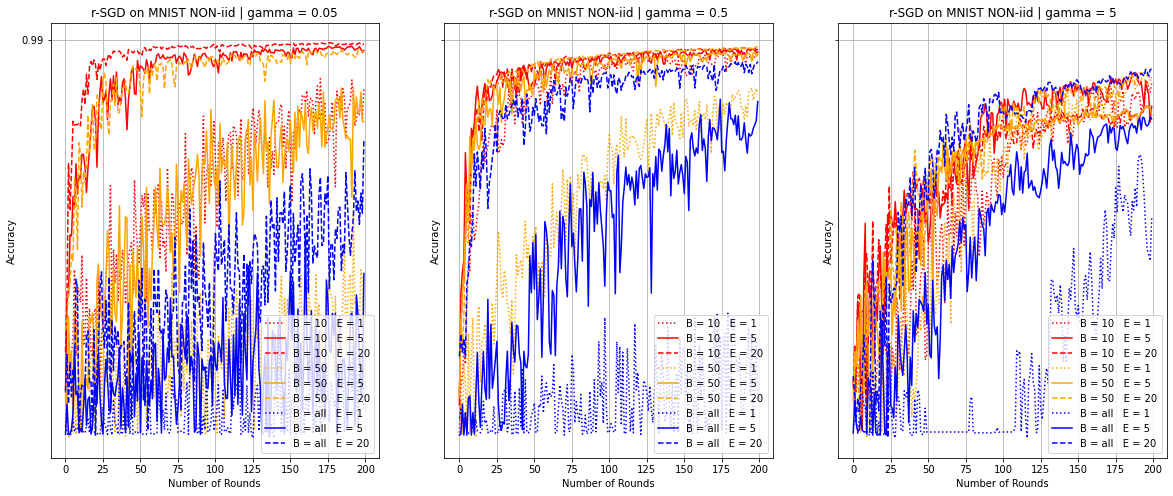

In [149]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True)
fig.set_size_inches(20, 8)

for ax, gamma in zip([ax1, ax2, ax3], [0.05, 0.5, 5]):
    for color, bs in zip(["red", "orange", "blue"],["10", "50", "all"]):
        for dash, e in zip([":", "-","--"], [1, 5, 20]):

            acc = rfed[(rfed["local_epochs"] == e) & 
                       (rfed["local_batchSize"]==bs) & 
                       (rfed["gamma"]==gamma) &
                       (rfed["iid"]==False)]["metrics"].item()["test_acc"]

            x = np.arange(len(acc))
            ax.plot(x, acc, color = color, linestyle = dash, label = "B = {}   E = {}".format(bs, e))
            ax.set(xlabel='Number of Rounds', ylabel='Accuracy', title = "r-SGD on MNIST NON-iid | gamma = {}".format(gamma))
            ax.set_yticks([.99])
            ax.grid()
        ax.legend(loc = "lower right")